# 1. Intro

Since this competition is so short, this week I want to focus on learning one skill, i.e. Hill Climbing. 

### What is Hill Climbing?

I first come across this idea in an interview with GM Amed Coulibaly who talked about this post by GM Chris Deotte: https://www.kaggle.com/competitions/feedback-prize-english-language-learning/discussion/369609. It is a way of ensembling predictions by iteratively finding the best next model and blending via a linear combination with the current best predictions. 

### Plan

Train various models using 5 fold CV and grid/random search, save out-of-fold preds, then ensemble predictions via hill climbing. 

### References

I used some preprocessing from [PS S03E03: 📊EDA + 📈16 models test = 🚀0.94+](https://www.kaggle.com/code/kirillka95/ps-s03e03-eda-16-models-test-0-94) to get started. I'll also refer EDA to this notebook.

### Libraries

In [6]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time
import umap

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, PredefinedSplit
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score,   roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# 2. Data

In [7]:
# Load data

train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sample_sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)

train = train_df
test = test_df
sub = sample_sub
#og = pd.read_csv("/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")
train.shape

(1677, 34)

Dataset is tiny to let's join with original data.

In [8]:

train_full = train_df
train_full.shape

(1677, 34)

In [9]:
# Preview data
train_full.head(3)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
id,,,,,,,,,,,,,,,,,,,,,
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,80,2,4,3,3,3,2,1,2,0


In [10]:
# Drop constant columns
train_full.drop(["EmployeeCount", "Over18", "StandardHours"], axis=1, inplace=True)
test.drop(["EmployeeCount", "Over18", "StandardHours"], axis=1, inplace=True)

# 3. Preprocessing

In [11]:
# Split features and labels
y = train_full["Attrition"]
X = train_full.drop("Attrition", axis=1)
X_test = test

In [12]:
# Categorical columns
cat_cols = [col for (col, d) in zip(X.columns,X.dtypes) if d == "object"]
cat_cols

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime']

In [13]:
# Encode cat columns
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

In [14]:
# Scale data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

### PCA

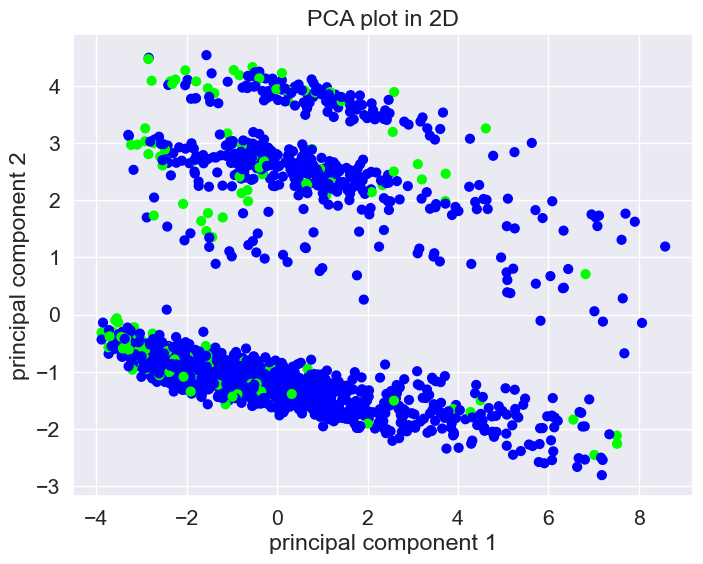

In [15]:
# PCA
pca = PCA()
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(data = X_pca)

# Scatterplot
plt.figure(figsize=(8,6))
plt.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], c=y, cmap="brg", s=40)
plt.title('PCA plot in 2D')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()

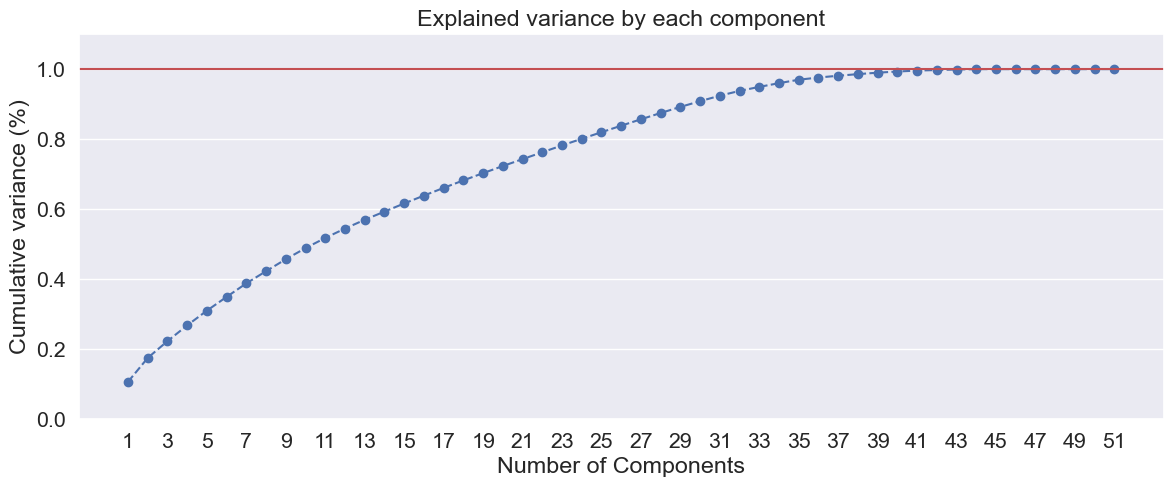

In [16]:
# Plot
plt.figure(figsize=(14,5))
xi = np.arange(1,1+X.shape[1], step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.gca().xaxis.grid(False)
plt.show()

# 4. Train models

In [17]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "ExtraTrees" : ExtraTreesClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'),
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

In [18]:
# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           "solver": ["liblinear"],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

In [19]:
# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "ExtraTrees" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [20]:
n_folds = 5

# Train models
for key, classifier in classifiers.items():
    # Initialise outputs
    test_preds = np.zeros(len(X_test))
    oof_full = y.copy()
    
    # Start timer
    start = time.time()
    
    # k-fold cross validation
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets
        X_train, X_valid = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[val_idx]
        
        # Start timer
        start = time.time()
        
        # Specify predefined validation set (-1 = train, 0 = valid)
        #split_idx = np.zeros(len(y))
        #split_idx[train_idx] = -1
        #ps = PredefinedSplit(split_idx)
        
        # Tune hyperparameters
        clf = RandomizedSearchCV(estimator=classifier, param_distributions=grid[key], n_iter=20, scoring='roc_auc', n_jobs=-1, cv=5)
        
        # Train using PredefinedSplit
        clf.fit(X_train, y_train)
        
        # Out-of-fold predictions
        oof_preds = clf.predict_proba(X_valid)[:,1]
        score += roc_auc_score(y_valid, oof_preds)/n_folds
        oof_full[val_idx] = oof_preds
        
        # Test set predictions
        test_preds += clf.predict_proba(X_test)[:,1]/n_folds
    
    # Stop timer
    stop = time.time()
    
    # Print score and time
    print('Model:', key)
    print('Average validation AUC:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
    # Plot ROC curve
    #plot_roc_curve(clf, X, y)
    #plt.legend([key])
    #plt.xlabel("False Positive Rate")
    #plt.ylabel("True Positive Rate")
    #plt.show()
    
    # Save oof and test set preds
    oof_full.to_csv(f"{key}_oof_preds.csv", index=False)
    ss = sub.copy()
    ss["Attrition"] = test_preds
    ss.to_csv(f"{key}_test_preds.csv", index=False)

Model: LogisticRegression
Average validation AUC: 81.45
Training time (mins): 0.0

Model: KNN
Average validation AUC: 72.77
Training time (mins): 0.0

Model: SVC
Average validation AUC: 80.02
Training time (mins): 0.05

Model: RandomForest
Average validation AUC: 82.39
Training time (mins): 0.03

Model: ExtraTrees
Average validation AUC: 81.74
Training time (mins): 0.03

Model: XGBoost
Average validation AUC: 80.91
Training time (mins): 0.03

Model: LGBM
Average validation AUC: 80.48
Training time (mins): 0.01



KeyboardInterrupt: 

# 5. Hill Climbing

In [16]:
# Join oof preds
oof_df = pd.DataFrame(index=np.arange(len(y)))
for i in classifiers.keys():
    df = pd.read_csv(f"/kaggle/working/{i}_oof_preds.csv")
    df.rename(columns={"Attrition": i}, inplace=True)
    oof_df = pd.concat([oof_df,df], axis=1)
    
# Join test preds
test_preds = pd.DataFrame(index=np.arange(len(X_test)))
for i in classifiers.keys():
    df = pd.read_csv(f"/kaggle/working/{i}_test_preds.csv")
    df.rename(columns={"Attrition": i}, inplace=True)
    test_preds = pd.concat([test_preds,df], axis=1)
    
oof_df.head(3)

,LogisticRegression,KNN,SVC,RandomForest,ExtraTrees,XGBoost,LGBM,CatBoost,NaiveBayes
0,0.529823,0.333333,0.426303,0.320335,0.274387,0.346006,0.276153,0.402876,0.945004
1,0.159061,0.000000,0.154772,0.087290,0.102770,0.043460,0.065143,0.063504,0.999873
2,0.018417,0.000000,0.031524,0.037521,0.029463,0.006169,0.010097,0.006738,0.096253


In [17]:
# Evaluate oof preds
scores = {}
for col in oof_df.columns:
    scores[col] = roc_auc_score(y, oof_df[col])

# Sort scores
scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}

# Sort oof_df and test_preds
oof_df = oof_df[list(scores.keys())]
test_preds = test_preds[list(scores.keys())]

scores

{'CatBoost': 0.8477340471345216,
 'XGBoost': 0.839012218497471,
 'LGBM': 0.8374754067906812,
 'LogisticRegression': 0.8371697332533965,
 'SVC': 0.8320070592010269,
 'RandomForest': 0.8316642319741274,
 'ExtraTrees': 0.8250838069021423,
 'NaiveBayes': 0.7603485691607488,
 'KNN': 0.7427330760721795}

In [18]:
# Initialise
STOP = False
current_best_ensemble = oof_df.iloc[:,0]
current_best_test_preds = test_preds.iloc[:,0]
MODELS = oof_df.iloc[:,1:]
history = []
i=0

# Hill climbing
while not STOP:
    i+=1
    potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
    history.append(potential_new_best_cv_score)
    k_best, wgt_best = None, None
    for k in MODELS:
        for wgt in np.arange(-0.5,0.51,0.01):
            potential_ensemble = (1-wgt) * current_best_ensemble + wgt * MODELS[k]
            cv_score = roc_auc_score(y, potential_ensemble)
            if cv_score > potential_new_best_cv_score:
                potential_new_best_cv_score = cv_score
                k_best, wgt_best = k, wgt
            
    if k_best is not None:
        current_best_ensemble = (1-wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
        current_best_test_preds = (1-wgt_best) * current_best_test_preds + wgt_best * test_preds[k_best]
        MODELS.drop(k_best, axis=1, inplace=True)
        if MODELS.shape[1]==0:
            STOP = True
        print(f'Iteration: {i}, Model added: {k_best}, Best weight: {wgt_best:.2f}, Best AUC: {potential_new_best_cv_score:.5f}')
    else:
        STOP = True

Iteration: 1, Model added: LogisticRegression, Best weight: 0.33, Best AUC: 0.85318
Iteration: 2, Model added: XGBoost, Best weight: 0.21, Best AUC: 0.85490
Iteration: 3, Model added: RandomForest, Best weight: 0.11, Best AUC: 0.85533
Iteration: 4, Model added: ExtraTrees, Best weight: -0.12, Best AUC: 0.85584
Iteration: 5, Model added: NaiveBayes, Best weight: 0.01, Best AUC: 0.85594
Iteration: 6, Model added: KNN, Best weight: 0.01, Best AUC: 0.85599
Iteration: 7, Model added: SVC, Best weight: 0.01, Best AUC: 0.85602
Iteration: 8, Model added: LGBM, Best weight: -0.01, Best AUC: 0.85603


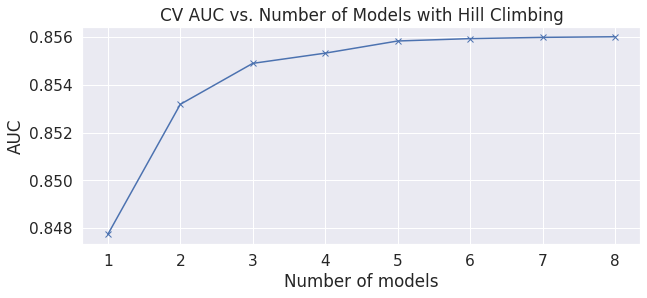

In [19]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(history))+1, history, marker="x")
plt.title("CV AUC vs. Number of Models with Hill Climbing")
plt.xlabel("Number of models")
plt.ylabel("AUC")
plt.show()

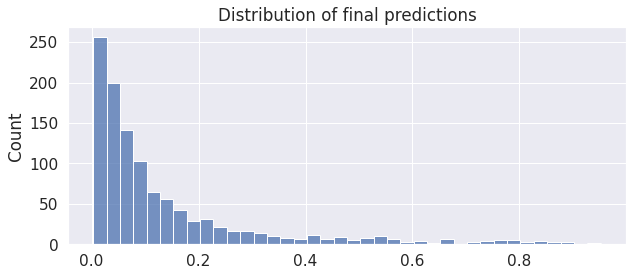

In [20]:
plt.figure(figsize=(10,4))
sns.histplot(current_best_test_preds)
plt.title("Distribution of final predictions")
plt.show()

In [21]:
# Submit predictions
submission = sub.copy()
submission["Attrition"] = current_best_test_preds.values
submission.to_csv("submission.csv", index=True)